In [2]:
# import libraries needed
from pathlib import Path
import os, yaml, time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# load in data
file_name = '../../Data/box_111_DM_particles.npz'
box_ID = file_name.split('/')[-1].split('_')[1]
particle_subsample = np.load(file_name)
x, y, z = particle_subsample['x'], particle_subsample['y'], particle_subsample['z']
vx, vy, vz = particle_subsample['vx'], particle_subsample['vy'], particle_subsample['vz'] 

In [3]:
def create_mask(x_start, y_start, z_start, size, x=x, y=y, z=z):
    newmask=(x>=x_start)&(x<x_start+size)&(y>=y_start)&(y<y_start+size)&(z>=z_start)&(z<z_start+size)
    newx=x[newmask]
    newy=y[newmask]
    newz=z[newmask]
    newvx=vx[newmask]
    newvy=vy[newmask]
    newvz=vz[newmask]
    return newx,newy,newz,newvx,newvy,newvz

In [4]:
def create_2d_density_plot(x_data,y_data,x_start,y_start,z_start,size,bins):
    histdata, xed, yed, colours = plt.hist2d(x_data,y_data,bins=bins)
    cbar = plt.colorbar(colours)
    cbar.set_label('Density')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    path = '../Figures/Density plot of size {:.0e} mpc cubed from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}) for box {}.png'.format(size**3,x_start,x_start+size,y_start,y_start+size,z_start,z_start+size,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return histdata

In [5]:
def create_3d_vector_plot(x_data,y_data,z_data,vx_data,vy_data,vz_data,x_start,y_start,z_start,size,sample):
    ax=plt.figure().add_subplot(111,projection='3d')
    ax.scatter(x_data[::sample],y_data[::sample],z_data[::sample],color='k')
    ax.quiver(x_data[::sample],y_data[::sample],z_data[::sample],vx_data[::sample],vy_data[::sample],vz_data[::sample],length=0.002,color='r',alpha=0.5)
    ax.set_xlabel('x coords')
    ax.set_ylabel('y coords')
    ax.set_zlabel('z coords')
    path = '../Figures/Sample of every {:.0f} velocity vectors from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}) for box {}.png'.format(sample, x_start,x_start+size,y_start,y_start+size,z_start,z_start+size,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [6]:
def create_histogram(histdata,bins,x_start,y_start,z_start,size):
    plt.hist(np.log10(histdata+1),bins=bins)
    plt.xlabel('Log10 density')
    plt.ylabel('Frequency')
    path = '../Figures/Histogram of density plot from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}) for box {}.png'.format(x_start,x_start+size,y_start,y_start+size,z_start,z_start+size,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [7]:
def full_density_histogram(grid,x=x,y=y,z=z):
    combined=np.column_stack((x,y,z))
    hist, edges = np.histogramdd(combined, bins=[grid,grid,grid])
    return hist, edges

In [8]:
def density_plot(z1,grid):
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicey=hist[:,:,z_bin[0]]
    plt.imshow(slicey, extent=[-1000, -500, -1000, -500], cmap='viridis')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.colorbar(label='Number of particles')
    path = '../Figures/Density plot along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed) for box {}.png'.format(z1,z1+grid,grid,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [9]:
def histogram2d(z1,grid):
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicey=hist[:,:,z_bin[0]]
    slicey=slicey.flatten()
    plt.hist(np.log10(slicey+1),bins=25)
    plt.xlabel('Log10 density')
    plt.ylabel('Frequency')
    path = '../Figures/Histogram of densities along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed) for box {}.png'.format(z1,z1+grid,grid,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [44]:
def density_with_velocities(z1,grid):
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicey=hist[:,:,z_bin[0]]
    z_bin = np.where((edges[2][:-1] >= -700) & (edges[2][:-1] < -690))[0]
    slicey=hist[:,:,z_bin[0]]
    velocitymask=(z<z1+grid)&(z>=z1)
    yvelo=vy[velocitymask]
    xvelo=vx[velocitymask]
    x_indices=np.digitize(xvelo,edges[0])-1
    y_indices=np.digitize(yvelo,edges[1])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    directx=np.zeros((bins,bins))
    directy=np.zeros((bins,bins))
    counts=np.zeros((bins,bins))
    np.add.at(directx, (xidx, yidx), xvelo)
    np.add.at(counts, (xidx, yidx), 1)
    np.add.at(directy, (xidx, yidx), yvelo)
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    checkerx=directx.T.flatten()
    checkery=directy.T.flatten()
    oo=np.array(list(np.linspace(-995,-505,bins))*bins)
    oo=np.sort(oo)
    ee=np.array(list(np.linspace(-995,-505,bins))*bins)
    plt.quiver(oo,ee,checkerx,checkery,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.legend(loc=2)
    plt.imshow(slicey, extent=[-1000, -500, -1000, -500], cmap='viridis')
    plt.colorbar(label='Number of particles')
    plt.show()
    return    

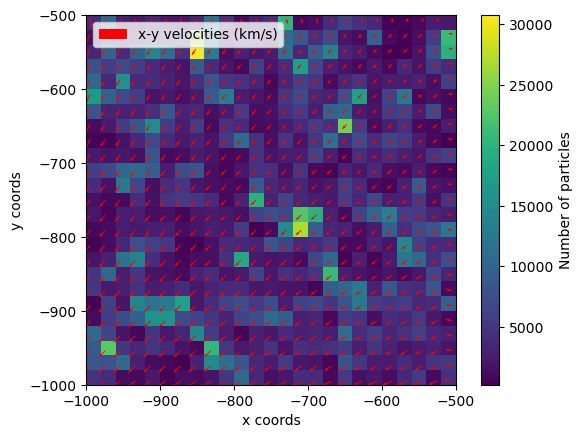

In [45]:
density_with_velocities(-700,20)

In [99]:
gridsize=10
zlim=-700
histogram2d(zlim,gridsize)
density_plot(zlim,gridsize)

In [ ]:
smolboxvol=gridsize**3
fullhist,ed=full_density_histogram(int(500/gridsize))
densities=fullhist/smolboxvol
otherav=len(x)/(500**3)
avg=0.03*6912**3/(2000**3)
print(otherav,avg)
print(np.mean(densities.flatten()))

0.5973542 1.23834728448
0.5973542


In [213]:
#create_3d_vector_plot(maskedx,maskedy,maskedz,maskedvx,maskedvy,maskedvz,startx,starty,startz,extent,500)
smallboxvol=0.5*0.5*100
for i in range(1):
    maskedx,maskedy,maskedz,maskedvx,maskedvy,maskedvz=create_mask(startx,starty,startz+i*100,extent)
    val=create_2d_density_plot(maskedx,maskedy,startx,starty,startz+i*100,extent,extent*2)
    oo=val.flatten()
    create_histogram(oo,50,startx,starty,startz+i*100,extent)